In [1]:


%load_ext autoreload
%autoreload 2

from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = (350, 350)
IPythonConsole.drawOptions.addAtomIndices = True
from openchemie import OpenChemIE
from PIL import Image
import numpy as np
from rdkit.Chem import AllChem
import cv2
import re
import torch
from openchemie import utils



import json
import copy

/Mounts/rbg-storage1/users/urop/vincentf/miniconda3/envs/openchemie/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = OpenChemIE(device = torch.device('cuda'))

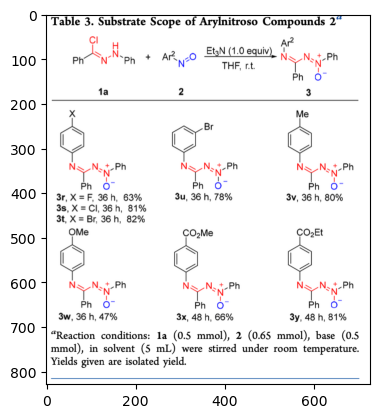

In [3]:
file_name = 'acs.joc.3c01427 example 2.png'

image_file = '../data/' + file_name

image = Image.open(image_file)

image_np = np.array(image)

plt.imshow(image_np)
plt.show()

In [4]:
results = model.extract_reactions_from_figures([image_np])

coref_results = model.extract_molecule_corefs_from_figures([image_np])

/Mounts/rbg-storage1/users/urop/vincentf/miniconda3/envs/openchemie/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Mounts/rbg-storage1/users/urop/vincentf/miniconda3/envs/openchemie/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Mounts/rbg-storage1/users/urop/vincentf/miniconda3/envs/openchemie/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATe

Inspect the RxnScribe Outputs

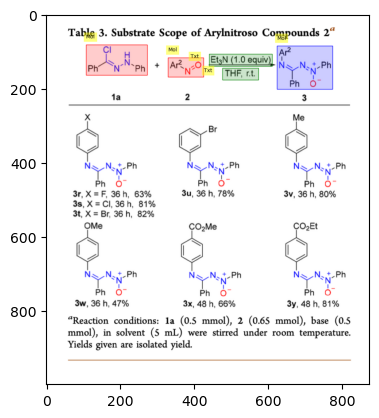

In [5]:
output = model.rxnscribe.draw_predictions(results[0]['reactions'], image_file = image_file)
plt.imshow(output[0])

{'COc1ccc(/N=C(\\N=[N+](/[O-])c2ccccc2)c2ccccc2)cc1': ['36 h, 47%', '3w,'], '*c1ccc(/N=C(\\N=[N+](/[O-])c2ccccc2)c2ccccc2)cc1': ['X=F, 36 h,', '63%', 'X=Cl; 36 h,', '81%', '3t,', 'X =Br; 36 h,', '82%', '30 ,', '35,'], 'Cl/C(=N\\Nc1ccccc1)c1ccccc1': ['1a'], '*N=O': ['2'], '[O-]/[N+](=N\\C(=N/c1cccc(Br)c1)c1ccccc1)c1ccccc1': ['36 h, 78%', '3u,'], 'COC(=O)c1ccc(/N=C(\\N=[N+](/[O-])c2ccccc2)c2ccccc2)cc1': ['48 h, 66%', '3X,'], '*/N=C(\\N=[N+](/[O-])c1ccccc1)c1ccccc1': ['3'], 'CCOC(=O)c1ccc(/N=C(\\N=[N+](/[O-])c2ccccc2)c2ccccc2)cc1': ['48 h, 81%', '3y,'], 'Cc1ccc(/N=C(\\N=[N+](/[O-])c2ccccc2)c2ccccc2)cc1': ['36 h, 80%', '3v,']}


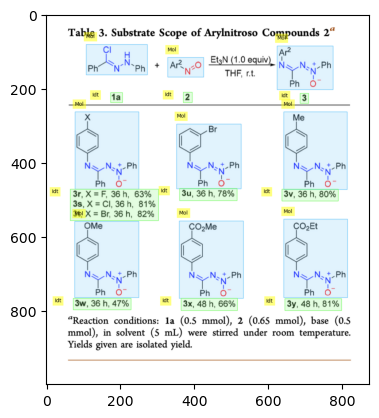

In [6]:
coref_output = model.moldet.draw_bboxes(coref_results[0], image_file = image_file, coref = True)

plt.imshow(coref_output[0])

coref_results_dict = {coref_results[0]['bboxes'][coref[0]]['smiles']: coref_results[0]['bboxes'][coref[1]]['text']  for coref in coref_results[0]['corefs']}

print(coref_results_dict)

Cl/C(=N\Nc1ccccc1)c1ccccc1


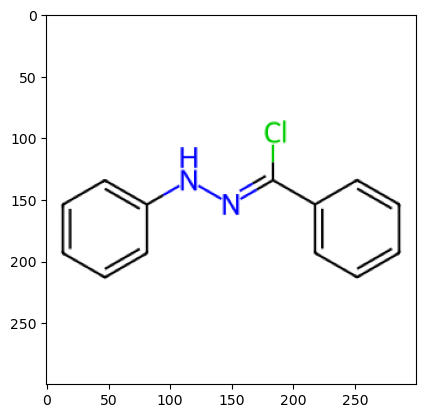

*N=O


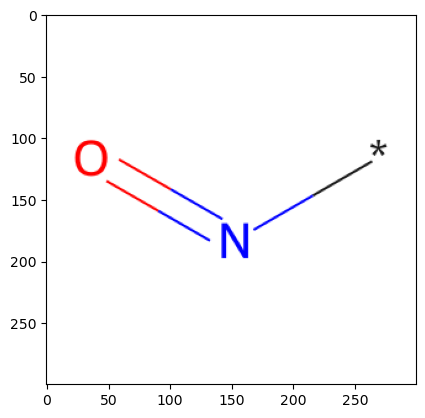

*/N=C(\N=[N+](/[O-])c1ccccc1)c1ccccc1


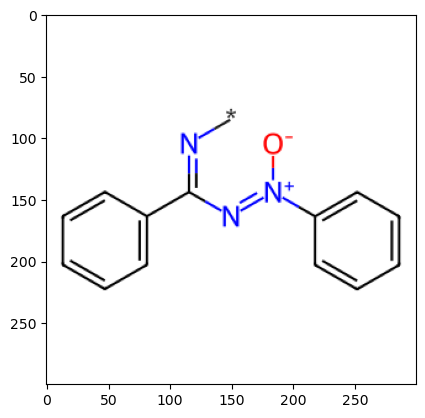

In [7]:
reactants_array = []
products = []

for reactant in results[0]['reactions'][0]['reactants']:
    print(reactant['smiles'])
    reactants_array.append(reactant['smiles'])
    i = Draw.MolToImage(Chem.MolFromSmiles(reactant['smiles']))
    plt.imshow(i)
    plt.show()
for product in results[0]['reactions'][0]['products']:
    print(product['smiles'])
    products.append(product['smiles'])
    i = Draw.MolToImage(Chem.MolFromSmiles(product['smiles']))
    plt.imshow(i)
    plt.show()

backout the reactants and do manual evaluation

In [10]:
backed_out = utils.backout(results, coref_results, model.molscribe)

In [11]:
backed_out

[(['Cl/C(=N\\Nc1ccccc1)c1ccccc1', 'COc1ccc(N=O)cc1'], '3w,'),
 (['Cl/C(=N\\Nc1ccccc1)c1ccccc1', '*c1ccc(N=O)cc1'], '3t,'),
 (['Cl/C(=N\\Nc1ccccc1)c1ccccc1', 'O=Nc1cccc(Br)c1'], '3u,'),
 (['Cl/C(=N\\Nc1ccccc1)c1ccccc1', 'COC(=O)c1ccc(N=O)cc1'], '3X,'),
 (['Cl/C(=N\\Nc1ccccc1)c1ccccc1', 'CCOC(=O)c1ccc(N=O)cc1'], '3y,'),
 (['Cl/C(=N\\Nc1ccccc1)c1ccccc1', 'Cc1ccc(N=O)cc1'], '3v,')]

these are the predicted reactants corresponding the product with label 3w,
Cl/C(=N\Nc1ccccc1)c1ccccc1


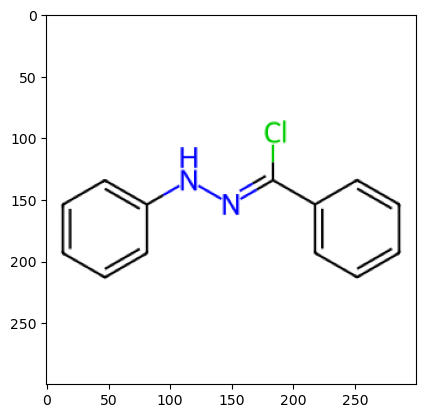

COc1ccc(N=O)cc1


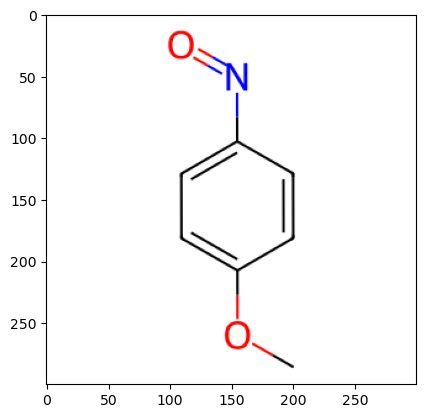

these are the predicted reactants corresponding the product with label 3t,
Cl/C(=N\Nc1ccccc1)c1ccccc1


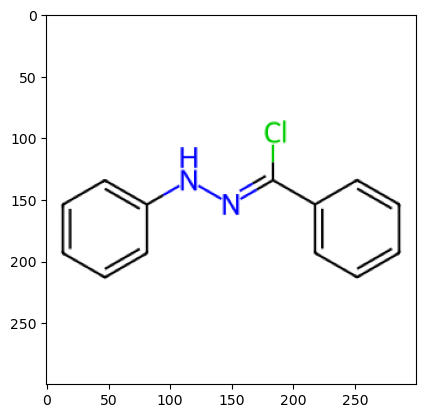

*c1ccc(N=O)cc1


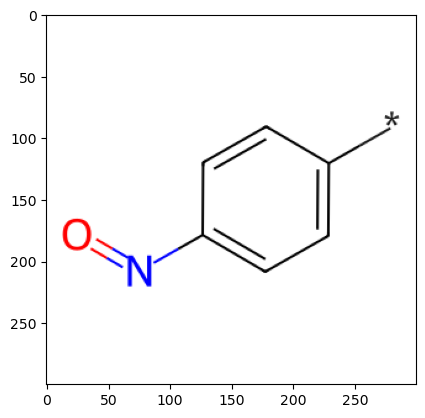

these are the predicted reactants corresponding the product with label 3u,
Cl/C(=N\Nc1ccccc1)c1ccccc1


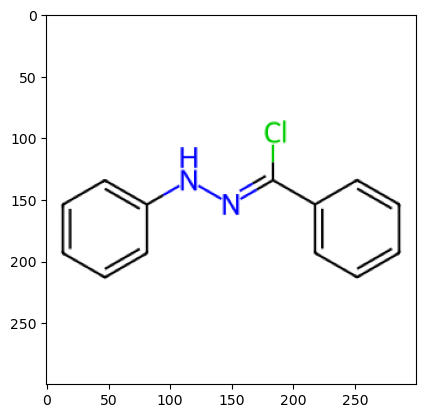

O=Nc1cccc(Br)c1


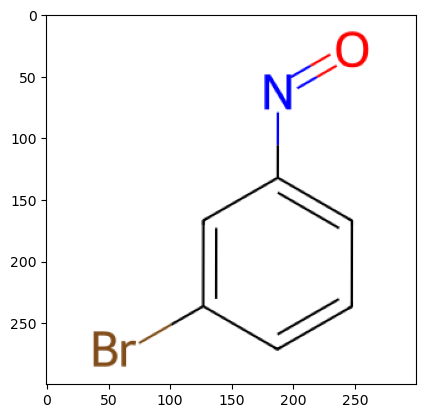

these are the predicted reactants corresponding the product with label 3X,
Cl/C(=N\Nc1ccccc1)c1ccccc1


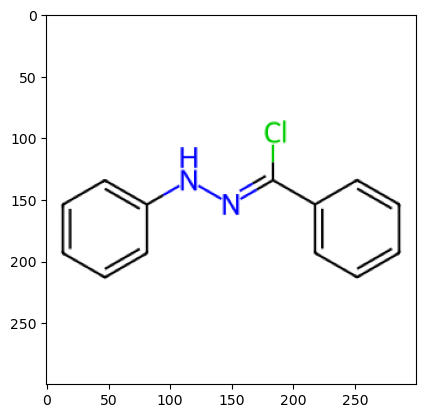

COC(=O)c1ccc(N=O)cc1


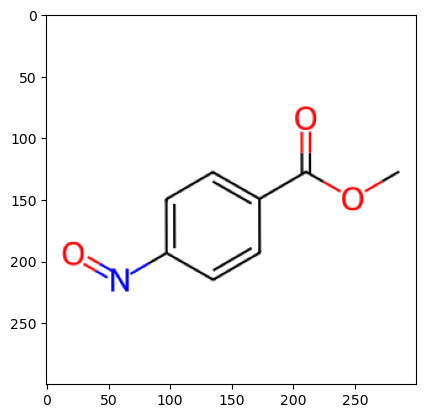

these are the predicted reactants corresponding the product with label 3y,
Cl/C(=N\Nc1ccccc1)c1ccccc1


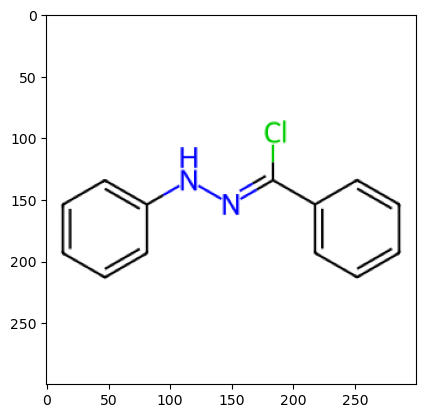

CCOC(=O)c1ccc(N=O)cc1


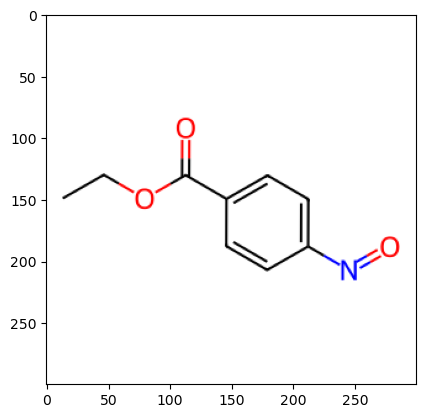

these are the predicted reactants corresponding the product with label 3v,
Cl/C(=N\Nc1ccccc1)c1ccccc1


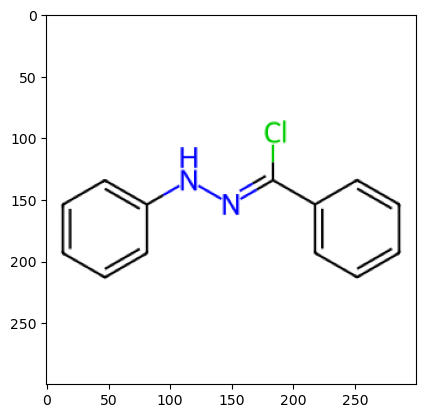

Cc1ccc(N=O)cc1


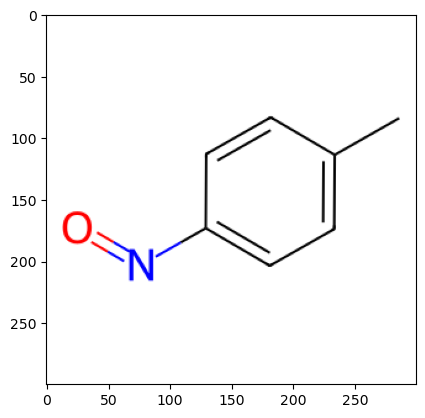

In [12]:
extracted_reactants = {}

for reactants, _, label in backed_out:
    print(f'these are the predicted reactants corresponding the product with label {label}')
    extracted_reactants[label] = []
    for molecule in reactants:
        print(molecule)
        extracted_reactants[label].append(molecule)
        i = Draw.MolToImage(Chem.MolFromSmiles(molecule))
        plt.imshow(i)
        plt.show()